In [ ]:
pip install umap-learn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=375fc4d3384ec57a66ad841663f1b80351a51bc73e43f3e8517d3dd638b8d489
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=60006ae1c03bd225ad49e160402d84fa82d26136d027333e5114e70f6f6342c4
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
!nvidia-smi

Fri May 19 06:28:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd # Datafram
import numpy as np # Array and math
import matplotlib.pylab as plt # Plot
import umap  # pip install umap-learn 
import io # Path
import re # Replace string to clean data
import nltk # Using stopwords
nltk.download('stopwords')
nltk.download('punkt')
import time
import gc
import torch 
import torch.nn as nn # Using and create module, class
import torch.optim as optim # Optimization
from nltk.tokenize import word_tokenize # Tokenize text
from nltk.stem import PorterStemmer # Filler out the short word
from nltk.corpus import stopwords # Stopwords
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence # Padding 
from torch.utils.data import DataLoader, TensorDataset # Divide into batch, create dataset for training
from sklearn.datasets import fetch_20newsgroups # Dataset
from sklearn.model_selection import train_test_split # Split train - test for lstm model
from sklearn.manifold import TSNE # T-sne algorithm
from sklearn.decomposition import PCA # PCA algorithm
from sklearn.preprocessing import StandardScaler # Scaler
from sklearn.model_selection import cross_val_score # Choose hyperparameters
from tqdm.notebook import tqdm # Information when train, test
from sklearn.neighbors import KNeighborsClassifier # KNN for classification
from sklearn.metrics import accuracy_score # Check algorithm is good or not

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Embedding text using pre-train model and applying umap, t-SNE
### In this part, we have
- Load data set which is fetch_20newsgroups in sklearn.
- Text cleaning by eliminating stopwords and fill out short words.
- Drop all columns which is not meaningful.
- Tokenize text and using pre-train model of glove to embed.
- Apply umap.
- Apply t-SNE.
- Compare two results


In [ ]:
def load_data():
    # Load dataset 20newsgroups from sklearn
    dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
    
    # Convert data to dataframe
    df = pd.DataFrame()
    df['text'] = dataset.data
    df['source'] = dataset.target
    return df  

def text_cleaner(text):
    cleaner = re.sub(r"[^a-zA-Z ]+", ' ', text.lower()) # Lowercase and strip everything except words
    cleaner = word_tokenize(cleaner) # Tokenize text to words
    
    stopWords = set(stopwords.words('english')) # Download stopwords English from nltk
    ps = PorterStemmer() # Initial filler out short words
    clean = []
    for w in cleaner:
        # filter out stopwords
        if w not in stopWords:
            # filter out short words
            if len(w)>2:
                # Stem 
                clean.append(ps.stem(w))
    return clean


def get_final_data(text_column, clean_text_column, target_column):
    df = load_data() # Load data
    df[clean_text_column] = df[text_column].apply(lambda x: text_cleaner(x)) # data cleaning
    df['len_sentence'] = df[clean_text_column].apply(lambda x: len(x)) # Get len of text
    df = df.drop(df[df['len_sentence'] == 0].index) # Drop text don't have any word
    return df

def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') # Read file
    vocab, matrix = [], []
    for line in fin: # Each line
        tokens = line.rstrip().split(' ') # Tokenize
        vocab.append(tokens[0]) # Add vocab
        matrix.append(list(map(float, tokens[1:]))) # Add embedding
    return vocab, matrix

def get_embedding_glove():
    !wget http://nlp.stanford.edu/data/glove.6B.zip # Download glove
    !unzip glove.6B.zip # Unzip or extract file
    vocab, matrix = load_word_embeddings("glove.6B.100d.txt") # Get embedding matrix with glove have 100 dim
    return vocab, matrix

def text_to_index(tokenized_texts, vocab, __UNKNOWN_WORD__):
    X = []
    word_to_index = {word: index+2 for index, word in enumerate(vocab)}

    for text in tokenized_texts:
        cur_text_indices = []
        for word in text:
            if word in word_to_index:
                cur_text_indices.append(word_to_index[word])    
            else:
                cur_text_indices.append(__UNKNOWN_WORD__)       
        X.append(cur_text_indices)
    return X


def get_index_embedding(tokenized_texts, df, target_column):
    vocab, matrix = get_embedding_glove() # Get embedding matrix from glove
    embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)  # Padding to equal length
    X = text_to_index(tokenized_texts, vocab, __UNKNOWN_WORD__) # Convert our text to index using above embedding matrix
    y = df[target_column].values # Get target
    return X, y, embedding_matrix


def get_embedding_matrix(X, embedding_matrix):
    text_embedding = [] 
    for text_index in X: # Each text
        embeddings = []
        for word_index in text_index: # Each word
            embeddings.append(embedding_matrix[word_index]) # Get embedding vector from pre-train model
        text_embedding.append(np.mean(embeddings, axis=0)) # Using mean for all vector of text
    return text_embedding
        
        
def umap_reduce_dim(X_train, y_train, X_test):
    manifold = umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42,
    ).fit(X_train, y_train)
    X_reduced_train = manifold.transform(X_train)
    X_reduced_test = manifold.transform(X_test)
    return X_reduced_train, X_reduced_test
    
def t_sne_reduce_dim(X_train, X_test):
    tsne = TSNE(n_components=2, perplexity=30, verbose=1, random_state=123)
    X_reduced_train = tsne.fit_transform(np.array(X_train))
    X_reduced_test = tsne.fit_transform(np.array(X_test))
    return X_reduced_train, X_reduced_test
  
def pca_reduce_dim(X_train, y_train, X_test):
    pca = PCA(n_components=2)
    pca.fit(X_train, y_train)
    X_reduced_train = pca.transform(X_train) 
    X_reduced_test = pca.transform(X_test) 
    return X_reduced_train, X_reduced_test


def plot_scatter(X, labels):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.5, cmap='Spectral')
    plt.show()


def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 10)
    return X_train, X_test, y_train, y_test

def find_best_k(X_train, y_train):
    k_values = [i for i in range (1,31)]
    scores = []

    scaler = StandardScaler()
    X = scaler.fit_transform(X_train)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X_train, y_train, cv=5)
        scores.append(np.mean(score))
    best_index = np.argmax(scores)
    return best_index


def KNN_classifier(X_train, y_train, X_test, k=2):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    KNeighborsClassifier(...)
    y_pred = neigh.predict(X_test)
    return y_pred, time.time() - start_time

In [ ]:
# Initial
__UNKNOWN_WORD__ = 1 
text_column = 'text'
clean_text_column = 'clean_text_stem'
target_column = 'source'
n_class = 20  

In [ ]:
df = get_final_data(text_column, clean_text_column, target_column)
tokenized_texts = df[clean_text_column].to_list()
X_index, y_label, embedding_matrix = get_index_embedding(tokenized_texts, df, target_column)

--2023-05-19 06:30:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-19 06:30:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-19 06:30:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
text_embedding = get_embedding_matrix(X_index, embedding_matrix)

In [ ]:
X_train, X_test, y_train, y_test = split_train_test(text_embedding, y_label)

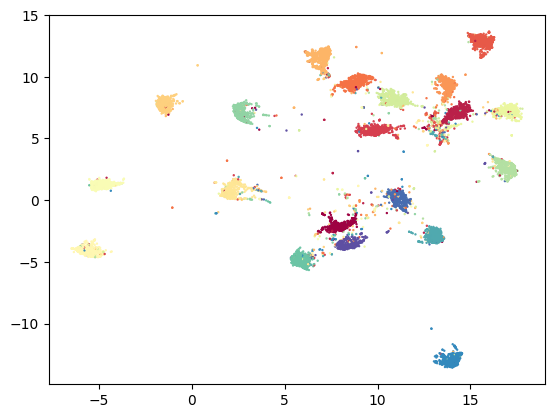

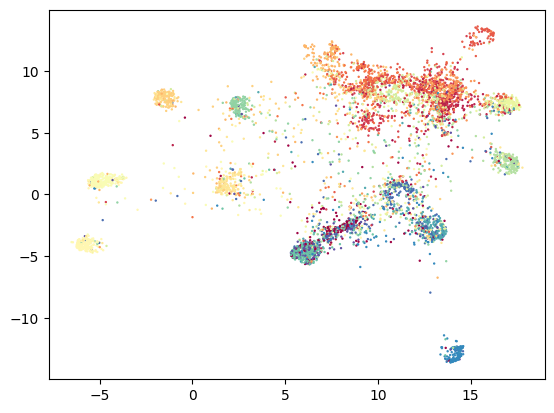

In [ ]:
X_reduced_train_umap, X_reduced_test_umap = umap_reduce_dim(X_train, y_train, X_test)
plot_scatter(X_reduced_train_umap, y_train)
plot_scatter(X_reduced_test_umap, y_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12806 samples in 0.001s...
[t-SNE] Computed neighbors for 12806 samples in 2.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12806
[t-SNE] Computed conditional probabilities for sample 2000 / 12806
[t-SNE] Computed conditional probabilities for sample 3000 / 12806
[t-SNE] Computed conditional probabilities for sample 4000 / 12806
[t-SNE] Computed conditional probabilities for sample 5000 / 12806
[t-SNE] Computed conditional probabilities for sample 6000 / 12806
[t-SNE] Computed conditional probabilities for sample 7000 / 12806
[t-SNE] Computed conditional probabilities for sample 8000 / 12806
[t-SNE] Computed conditional probabilities for sample 9000 / 12806
[t-SNE] Computed conditional probabilities for sample 10000 / 12806
[t-SNE] Computed conditional probabilities for sample 11000 / 12806
[t-SNE] Computed conditional probabilities for sample 12000 / 12806
[t-SNE] Computed conditional probabilities for sam

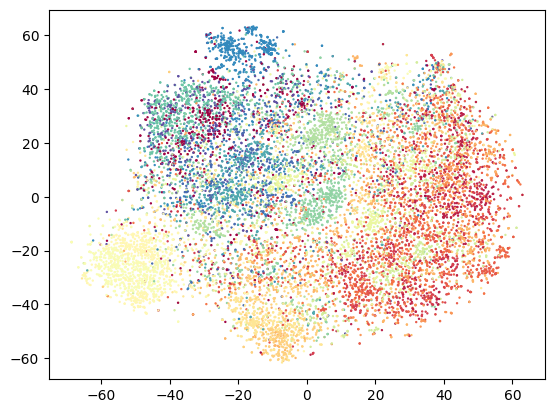

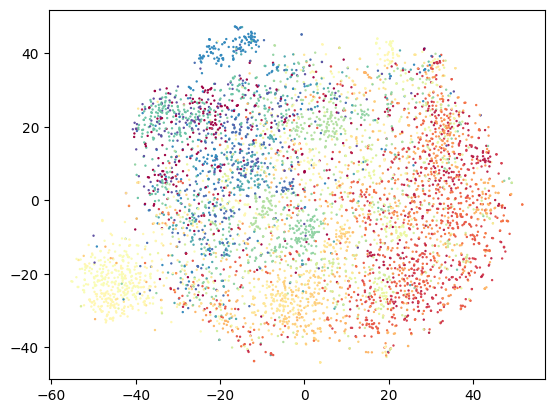

In [ ]:
X_reduced_train_tsne, X_reduced_test_tnse = t_sne_reduce_dim(X_train, X_test)
plot_scatter(X_reduced_train_tsne, y_train)
plot_scatter(X_reduced_test_tnse, y_test)

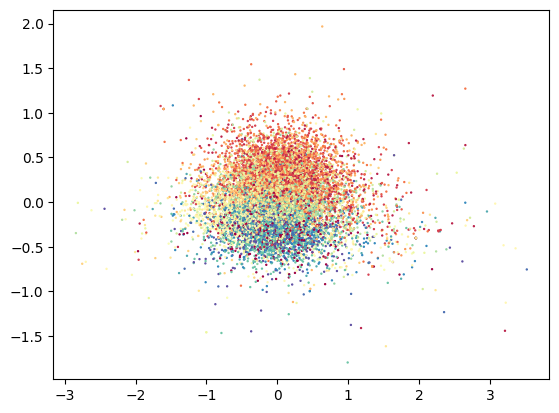

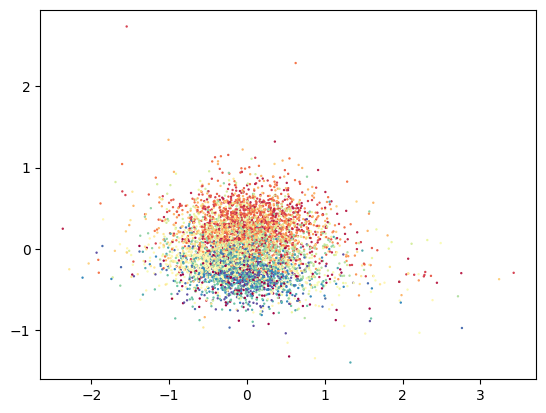

In [ ]:
X_reduced_train_pca, X_reduced_test_pca = pca_reduce_dim(X_train, y_train, X_test)
plot_scatter(X_reduced_train_pca, y_train)
plot_scatter(X_reduced_test_pca, y_test)

In [ ]:
k_umap = find_best_k(X_reduced_train_pca, y_train)
y_pred_umap, time_umap = KNN_classifier(X_reduced_train_umap, y_train, X_reduced_test_umap, k_umap)
accuracy_umap = accuracy_score(y_test, y_pred_umap)
print("Accuracy:", accuracy_umap)
print("Time of umap:", time_umap)

Accuracy: 0.45345235926398253
Time of umap: 0.15641379356384277


In [ ]:
y_pred_umap, time_umap = KNN_classifier(X_reduced_train_umap, y_train, X_reduced_test_umap, k_umap+1)
accuracy_umap = accuracy_score(y_test, y_pred_umap)
print("Accuracy:", accuracy_umap)
print("Time of umap:", time_umap)

Accuracy: 0.4547276370923666
Time of umap: 0.27538084983825684


In [ ]:
y_pred_umap, time_umap = KNN_classifier(X_reduced_train_umap, y_train, X_reduced_test_umap, k_umap+2)
accuracy_umap = accuracy_score(y_test, y_pred_umap)
print("Accuracy:", accuracy_umap)
print("Time of umap:", time_umap)

Accuracy: 0.45527418473310255
Time of umap: 0.22911882400512695


In [ ]:
k_tsne = find_best_k(X_reduced_train_tsne, y_train)
y_pred_tsne, time_tsne = KNN_classifier(X_reduced_train_tsne, y_train, X_reduced_test_tnse, k_tsne)
accuracy_tsne = accuracy_score(y_test, y_pred_tsne)
print("Accuracy:", accuracy_tsne)
print("Time of umap:", time_tsne)

Accuracy: 0.16123155401712516
Time of umap: 0.131744384765625


In [ ]:
y_pred_tsne, time_tsne = KNN_classifier(X_reduced_train_tsne, y_train, X_reduced_test_tnse, k_tsne+1)
accuracy_tsne = accuracy_score(y_test, y_pred_tsne)
print("Accuracy:", accuracy_tsne)
print("Time of umap:", time_tsne)

Accuracy: 0.16542175259610128
Time of umap: 0.1226508617401123


In [ ]:
y_pred_tsne, time_tsne = KNN_classifier(X_reduced_train_tsne, y_train, X_reduced_test_tnse, k_tsne+2)
accuracy_tsne = accuracy_score(y_test, y_pred_tsne)
print("Accuracy:", accuracy_tsne)
print("Time of umap:", time_tsne)

Accuracy: 0.1716159591911095
Time of umap: 0.13315081596374512


In [ ]:
k_pca = find_best_k(X_reduced_train_pca, y_train)
y_pred_pca, time_pca = KNN_classifier(X_reduced_train_pca, y_train, X_reduced_test_pca, k_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy_pca)
print("Time of umap:", time_pca)

Accuracy: 0.14228456913827656
Time of umap: 0.13420438766479492


In [ ]:
y_pred_pca, time_pca = KNN_classifier(X_reduced_train_pca, y_train, X_reduced_test_pca, k_pca+1)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy_pca)
print("Time of umap:", time_pca)

Accuracy: 0.14264893423210057
Time of umap: 0.13787436485290527


In [ ]:
y_pred_pca, time_pca = KNN_classifier(X_reduced_train_pca, y_train, X_reduced_test_pca, k_pca+2)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy_pca)
print("Time of umap:", time_pca)

Accuracy: 0.14501730734195664
Time of umap: 0.1500988006591797


## Another way to embed text: Using LSTM to train after embedding from pre-train model.
- Split train - test data.
- Convert these data to tensor.
- Divide into many batches.
- Build LSTM model including embedding layer - using pre-train model, LSTM layer which have output we use to embedding martrix, FC layer.
- Inititalize object which is cross entropy and optimizer which is Adam.
- Get embedding matrix and apply umap, t-SNE

In [ ]:
# Split train - test for lstm task, 
X_train, X_valid, y_train, y_valid =  split_train_test(X_index, y_label)

In [ ]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = [torch.tensor(input, dtype=torch.long) for input in inputs]
    seq_len = [len(input) for input in inputs]
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    seq_len = torch.tensor(seq_len)
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    return inputs, seq_len, labels


def create_attention_mask(sequence_lengths, max_length):
    batch_size = len(sequence_lengths)
    attention_masks = torch.zeros(batch_size, max_length, dtype=torch.float32)

    for i, seq_len in enumerate(sequence_lengths):
        attention_masks[i, :seq_len] = 1.0

    return attention_masks


def mean_pooling(token_embeddings, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, n_class):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=128, bidirectional=True)
        self.fc = nn.Linear(256, n_class)

    def forward(self, x, attn_mask):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm(x)
        output = mean_pooling(output, attn_mask)
        # x = self.fc(hidden.squeeze(0))
        x = self.fc(output).squeeze()
        return x, output

    
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

    
train_dataset = NewsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataset = NewsDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)


device = 'cuda:0'
# Initialize the model, loss, and optimizer
model = LSTMModel(embedding_matrix, n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-4)

In [ ]:
# Training loop
num_epochs = 20
torch.cuda.empty_cache()
gc.collect()
ans = []
for epoch in range(num_epochs):
    model.train()
    train_tqdm = tqdm(train_loader, leave=True, desc='Training: ')
    for inputs, seq_len, targets in train_tqdm:      
        optimizer.zero_grad()
        inputs = inputs.to(device)
        seq_len = seq_len.to(device)
        attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
        targets = targets.to(device)
        outputs, embed = model(inputs, attn_mask)
        ans.append(embed)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, pred = torch.max(outputs, dim=1) 
            acc = (pred==targets).sum()/targets.size(0)
        train_tqdm.set_postfix(loss=loss.item(), accuracy=acc.item())

    # Validation
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        valid_tqdm = tqdm(valid_loader, leave=True, desc='Validation: ')
        for inputs, seq_len, targets in valid_tqdm:
            inputs = inputs.to(device)
            seq_len = seq_len.to(device)
            attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
            targets = targets.to(device)
            outputs, embed = model(inputs, attn_mask)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            with torch.no_grad():
                _, pred = torch.max(outputs, dim=1) 
                acc = (pred==targets).sum()/targets.size(0)
            valid_tqdm.set_postfix(loss=loss.item(), accuracy=acc.item())

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {valid_loss/len(valid_loader):.4f}, Accuracy: {correct/total*100:.2f}%")


Training:   0%|          | 0/801 [00:00<?, ?it/s]

<ipython-input-22-c3a851f7ada5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.3557, Accuracy: 60.98%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/20, Loss: 1.2346, Accuracy: 66.92%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/20, Loss: 1.2700, Accuracy: 67.24%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/20, Loss: 1.3221, Accuracy: 66.86%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/20, Loss: 1.3757, Accuracy: 67.02%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/20, Loss: 1.4656, Accuracy: 66.24%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/20, Loss: 1.4668, Accuracy: 65.08%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/20, Loss: 1.4520, Accuracy: 66.68%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/20, Loss: 1.4991, Accuracy: 66.33%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/20, Loss: 1.5001, Accuracy: 66.37%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 11/20, Loss: 1.4844, Accuracy: 66.35%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 12/20, Loss: 1.5062, Accuracy: 66.10%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 13/20, Loss: 1.5248, Accuracy: 66.44%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 14/20, Loss: 1.5159, Accuracy: 66.72%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 15/20, Loss: 1.5478, Accuracy: 66.57%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 16/20, Loss: 1.5261, Accuracy: 66.15%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 17/20, Loss: 1.5453, Accuracy: 65.39%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 18/20, Loss: 1.5492, Accuracy: 66.35%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 19/20, Loss: 1.5444, Accuracy: 67.33%


Training:   0%|          | 0/801 [00:00<?, ?it/s]

Validation:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 20/20, Loss: 1.5665, Accuracy: 66.21%


In [ ]:
dataset = NewsDataset(X_index, y_label)
embed_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
model.train()
embed_tqdm = tqdm(embed_loader, leave=True, desc='Training: ')
embedding_matrix_lstm = []
target_matrix = []
for inputs, seq_len, targets in embed_tqdm:      
    optimizer.zero_grad()
    inputs = inputs.to(device)
    seq_len = seq_len.to(device)
    attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
    targets = targets.to(device)
    outputs, embed = model(inputs, attn_mask)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    for i in range(len(embed)):
        embedding_matrix_lstm.append(embed[i].tolist())
        target_matrix.append(targets[i].tolist())
    
    with torch.no_grad():
        _, pred = torch.max(outputs, dim=1) 
        acc = (pred==targets).sum()/targets.size(0)
    embed_tqdm.set_postfix(loss=loss.item(), accuracy=acc.item())

Training:   0%|          | 0/572 [00:00<?, ?it/s]

<ipython-input-22-c3a851f7ada5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


In [ ]:
X_train, X_test, y_train, y_test = split_train_test(embedding_matrix_lstm, target_matrix)

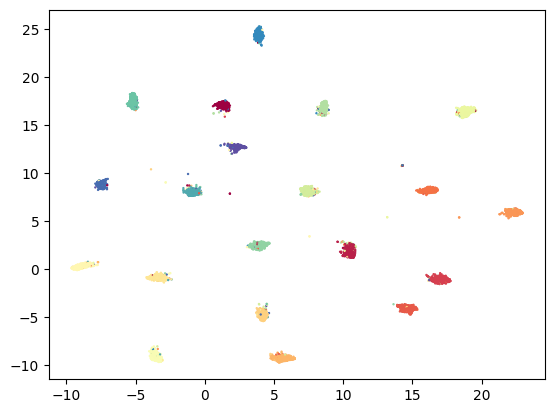

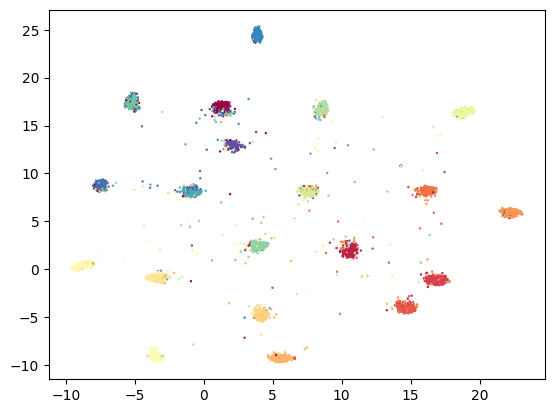

In [ ]:
X_reduced_train_umap, X_reduced_test_umap = umap_reduce_dim(X_train, y_train, X_test)
plot_scatter(X_reduced_train_umap, y_train)
plot_scatter(X_reduced_test_umap, y_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12806 samples in 0.003s...
[t-SNE] Computed neighbors for 12806 samples in 2.972s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12806
[t-SNE] Computed conditional probabilities for sample 2000 / 12806
[t-SNE] Computed conditional probabilities for sample 3000 / 12806
[t-SNE] Computed conditional probabilities for sample 4000 / 12806
[t-SNE] Computed conditional probabilities for sample 5000 / 12806
[t-SNE] Computed conditional probabilities for sample 6000 / 12806
[t-SNE] Computed conditional probabilities for sample 7000 / 12806
[t-SNE] Computed conditional probabilities for sample 8000 / 12806
[t-SNE] Computed conditional probabilities for sample 9000 / 12806
[t-SNE] Computed conditional probabilities for sample 10000 / 12806
[t-SNE] Computed conditional probabilities for sample 11000 / 12806
[t-SNE] Computed conditional probabilities for sample 12000 / 12806
[t-SNE] Computed conditional probabilities for sam

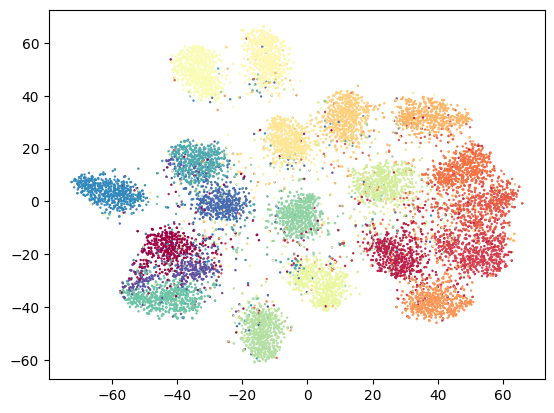

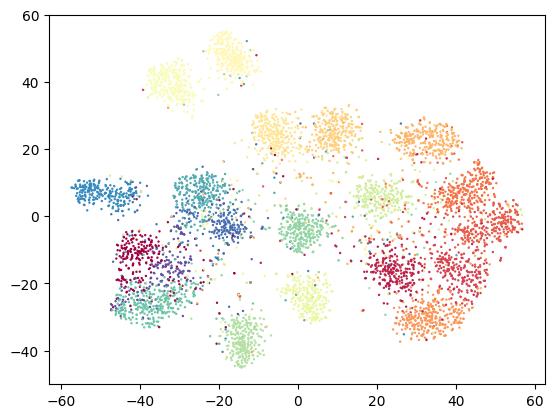

In [ ]:
X_reduced_train_tsne, X_reduced_test_tnse = t_sne_reduce_dim(X_train, X_test)
plot_scatter(X_reduced_train_tsne, y_train)
plot_scatter(X_reduced_test_tnse, y_test)

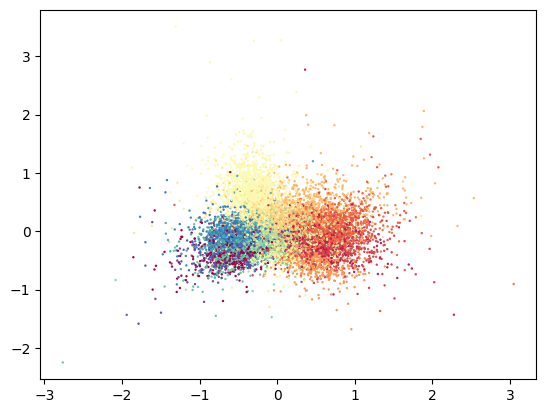

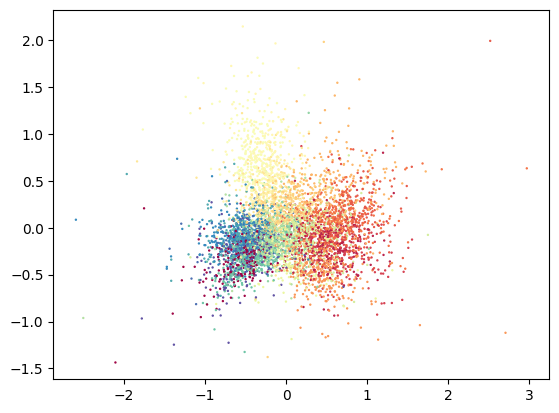

In [ ]:
X_reduced_train_pca, X_reduced_test_pca = pca_reduce_dim(X_train, y_train, X_test)
plot_scatter(X_reduced_train_pca, y_train)
plot_scatter(X_reduced_test_pca, y_test)

In [ ]:
k_umap = find_best_k(X_reduced_train_pca, y_train)
y_pred_umap, time_umap = KNN_classifier(X_reduced_train_umap, y_train, X_reduced_test_umap, k_umap)
accuracy_umap = accuracy_score(y_test, y_pred_umap)
print("Accuracy:", accuracy_umap)
print("Time of umap:", time_umap)

Accuracy: 0.8467844780470031
Time of umap: 0.13770270347595215


In [ ]:
k_tsne = find_best_k(X_reduced_train_tsne, y_train)
y_pred_tsne, time_tsne = KNN_classifier(X_reduced_train_tsne, y_train, X_reduced_test_tnse, k_tsne)
accuracy_tsne = accuracy_score(y_test, y_pred_tsne)
print("Accuracy:", accuracy_tsne)
print("Time of umap:", time_tsne)

Accuracy: 0.6607760976498451
Time of umap: 0.13250398635864258


In [ ]:
k_pca = find_best_k(X_reduced_train_pca, y_train)
y_pred_pca, time_pca = KNN_classifier(X_reduced_train_pca, y_train, X_reduced_test_pca, k_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy_pca)
print("Time of umap:", time_pca)

Accuracy: 0.33885953725633083
Time of umap: 0.13701200485229492
